# Predictive coding (Rao & Ballard, 1999) モデルの実装
このノートブックではPredictive codingの初めの数理的モデルとなる ([Rao & Ballard, *Nat. Neurosci*. 1999](https://www.nature.com/articles/nn0199_79))を解説し、Pythonによる実装を行います。

## 観測世界の階層的予測
構築するネットワークは入力層を含め、3層のネットワークとします。網膜への入力として画像 $\boldsymbol{I} \in \mathbb{R}^{n_0}$を考えます。画像 $\boldsymbol{I}$ の観測世界における隠れ変数、すなわち**潜在変数** (latent variable)を$\boldsymbol{r} \in \mathbb{R}^{n_1}$とし、ニューロン群によって発火率で表現されているとします (真の変数と $\boldsymbol{r}$は異なるので文字を分けるべきでしょうが簡単のためにこう表します)。このとき、

$$
\boldsymbol{I} = f(U\boldsymbol{r}) + \boldsymbol{n} \tag{1}
$$

が成立しているとします。ただし、$f(\cdot)$は活性化関数 (activation function)、$U \in \mathbb{R}^{n_0 \times n_1}$は重み行列です。$\boldsymbol{n} \in \mathbb{R}^{n_0} $は平均0, 分散 $\sigma^2$ のGaussian ノイズ項とします。

潜在変数 $\boldsymbol{r}$はさらに高次 (higher-level)の潜在変数 $\boldsymbol{r}^h$により、次式で表現されます。

$$
\boldsymbol{r} = \boldsymbol{r}^{td}+\boldsymbol{n}^{td}=f(U^h \boldsymbol{r}^h)+\boldsymbol{n}^{td} \tag{2}
$$

ただし、Top-downの予測信号を $\boldsymbol{r}^{td}:=f(U^h \boldsymbol{r}^h)$としました。また、$\boldsymbol{r}^{td} \in \mathbb{R}^{n_1}, \boldsymbol{r}^{h} \in \mathbb{R}^{n_2}, U^h \in \mathbb{R}^{n_1 \times n_2} $です。$\boldsymbol{n}^{td} \in \mathbb{R}^{n_1} $は平均0, 分散 $\sigma_{td}^2$ のGaussian ノイズ項とします。

話は飛びますが、Predictive codingのネットワークは下図のように表されます。特徴は
- 階層的な構造
- 高次による低次の予測 (Feedback or Top-down信号)
- 低次から高次への誤差信号の伝搬 (Feedforward or Bottom-up 信号)

です。

<img src=" https://salad-bowl-of-knowledge.github.io/hp/images/copied_from_nb/images/predictive-coding_figs/fig1a.JPG" width="500px">
<div style="text-align: right;"> (Rao and Ballard, 1999; Fig. 1a)</div>

ここまで、高次表現による低次表現の予測、というFeedback信号について説明しました。それではPredictive codingのもう一つの要となる、低次から高次への予測誤差の伝搬というFeedforward信号はどのように導かれるのでしょうか。結論から言えば、これは**復元誤差 (reconstruction error)の最小化を行う再帰的ネットワーク (recurrent network)を考慮することで自然に導かれます**。

## 生成モデル的表現とMAP推定
### 尤度の設定
ネットワークの損失関数を導くために**生成モデル** (generative model)的な表現をしてみましょう。潜在変数 (あるいはCauses) $\boldsymbol{r}$の事前分布 (prior)を$p(\boldsymbol{r})$,  入力画像 $\boldsymbol{I}$の尤度 (likelihood)を$p(\boldsymbol{I}|\boldsymbol{r}; U)$とします。(1)式およびノイズ項を$\boldsymbol{n}\sim\mathcal{N}(0, \sigma^2)$としたことから、

$$
\begin{align}
p(\boldsymbol{I}|\ \boldsymbol{r}; U)&=\mathcal{N}\left(\boldsymbol{I}|\ f(U\boldsymbol{r}), \sigma^2\right)\\
&\varpropto \exp\left(-\frac{\|\boldsymbol{I} -  f(U\boldsymbol{r})\|^2}{\sigma^2}\right)
\end{align}
$$

と表せます。

### 事前分布の設定
事前分布$p(\boldsymbol{r})$に対してもGaussian分布を用いてもよいですが、 **Sparse coding** を考えると異なる分布を用いた方がよいでしょう。Sparse codingでは、$\boldsymbol{r}$の各要素$r_i$はほとんど0に等しく、ある入力に対しては大きな値を取る、というのが理想的です。この性質を考慮すると$p(\boldsymbol{r})$としては、0においてピークがあり、裾の重い(heavy tail)を持つsparse distributionあるいは **super-Gaussian distribution** (Laplace 分布やCauchy分布などGaussian分布よりもkurtoticな分布)を用いるのが良いでしょう。ここではGaussian分布またはCauchy分布の場合について考えてみます。なお、後で用いるために$p(\boldsymbol{r})$の負の対数事前分布を$g(\boldsymbol{r}):=-\log p(\boldsymbol{r})$とします。

#### Gaussian 分布を用いる場合
$$
\begin{align}
p(\boldsymbol{r})&=\exp(-\alpha\|\boldsymbol{r}\|^2)\\
g(\boldsymbol{r})&=-\ln p(\boldsymbol{r})=\alpha\|\boldsymbol{r}\|^2\\
g'(\boldsymbol{r})&=\frac{\partial g(\boldsymbol{r})}{\partial \boldsymbol{r}}=2\alpha\boldsymbol{r}
\end{align}\tag{3}
$$

#### Cauchy分布を用いる場合

$$
\begin{align}
p(\boldsymbol{r})&=\prod_i p(r_i)=\prod_i \exp\left[-\alpha \ln(1+r_i^2)\right]\\
g(\boldsymbol{r})&=-\ln p(\boldsymbol{r})=\alpha \sum_i \ln(1+r_i^2)\\
g'(\boldsymbol{r})&=\frac{\partial g(\boldsymbol{r})}{\partial \boldsymbol{r}}=\left[\frac{2\alpha r_i}{1+r_i^2}\right]_i
\end{align}\tag{4}
$$

いずれの分布を用いても良いですが、今回はCauchy分布を用います。

一方で、重み行列$U$の事前分布 $p(U)$はGaussian分布としておきます。$p(U)$の負の対数事前分布を$h(U):=-\ln p(U)$とすると、次のように表されます。

$$
\begin{align}
p(U)&=\exp(-\lambda\|U\|^2_F)\\
h(U)&=-\ln p(U)=\lambda\|U\|^2_F\\
h'(U)&=\frac{\partial h(U)}{\partial U}=2\lambda U
\end{align}\tag{5}
$$

ただし、$\|\cdot \|_F^2 $はフロベニウスノルムを意味します。

### MAP推定によるパラメータの最適化
MAP推定(最大事後確率推定)によりパラメータ $\boldsymbol{r}, U$を最適化することを考えます。まず、事後分布 (posterior)は

$$
p(\boldsymbol{r}, U|\boldsymbol{I})=k \cdot p(\boldsymbol{I}|\boldsymbol{r}, U) p(\boldsymbol{r})p(U)\tag{6}
$$

となります。ただし$k$は定数です。次に対数事後確率$F(\boldsymbol{r}, U):=\ln p(\boldsymbol{r}|\boldsymbol{I};U)$を考えます。

$$
\begin{align}
F(\boldsymbol{r}, U)
&=\ln p(\boldsymbol{I}|\boldsymbol{r}, U)+\ln p(\boldsymbol{r})+\ln p(U)+\ln k\\
&=-\frac{1}{\sigma^2}\|\boldsymbol{I} -  f(U\boldsymbol{r})\|^2-g(\boldsymbol{r})-h(U)+\ln k
\end{align}\tag{7}
$$

この$F$を最大化すれば$p(\boldsymbol{r}, U|\boldsymbol{I})$も最大となります。このためには勾配上昇法 (gradient ascent)を用いればよいです。ただ、一般のニューラルネットワークモデルと合わせるために$F$の符号を反転させて定数項を除いたものを損失関数 $E\ (\approx -F)$ とし、この$E$を最小化するために勾配降下法 (gradient descent)を適応することを次節で考えます。


## 損失関数と学習則
### 損失関数の設定
前節では2層までのパラメータを最適化することを考えましたが、高次の活動も考慮して損失関数 $E$を次のように再定義します。

$$
\begin{align}
E=\underbrace{\frac{1}{\sigma^{2}}\|\boldsymbol{I}-f(U \boldsymbol{r})\|^2+\frac{1}{\sigma_{t d}^{2}}\left\|\boldsymbol{r}-f(U^h \boldsymbol{r}^h)\right\|^2}_{\text{reconstruction error}}+\underbrace{g(\boldsymbol{r})+g(\boldsymbol{r}^{h})+h(U)+h(U^h)}_{\text{sparsity penalty}}\tag{8}
\end{align}
$$


### 再帰ネットワークの更新則
簡単のために$\boldsymbol{x}:=U\boldsymbol{r}, \boldsymbol{x}^h:=U^h\boldsymbol{r}^h$とします。

$$
\begin{align}
\frac{d \boldsymbol{r}}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \boldsymbol{r}}=k_{1}\cdot\Bigg(\frac{1}{\sigma^{2}} U^{T}\bigg[\frac{\partial f(\boldsymbol{x})}{\partial \boldsymbol{x}}\odot\underbrace{(\boldsymbol{I}-f(\boldsymbol{x}))}_{\text{bottom-up error}}\bigg]-\frac{1}{\sigma_{t d}^{2}}\underbrace{\left(\boldsymbol{r}-f(\boldsymbol{x}^h)\right)}_{\text{top-down error}}-\frac{1}{2}g'(\boldsymbol{r})\Bigg)\tag{9}\\
\frac{d \boldsymbol{r}^h}{d t}&=-\frac{k_{1}}{2} \frac{\partial E}{\partial \boldsymbol{r}^h}=k_{1}\cdot\Bigg(\frac{1}{\sigma_{t d}^{2}}(U^h)^T\bigg[\frac{\partial f(\boldsymbol{x}^h)}{\partial \boldsymbol{x}^h}\odot\underbrace{\left(\boldsymbol{r}-f(\boldsymbol{x}^h)\right)}_{\text{bottom-up error}}\bigg]-\frac{1}{2}g'(\boldsymbol{r}^h)\Bigg)\tag{10}
\end{align}
$$

ただし、$k_1$は更新率 (updating rate)です。または、発火率の時定数を$\tau:=1/k_1$として、$k_1$は発火率の時定数$\tau$の逆数であると捉えることもできます。ここで(9)式において、中間表現 $\boldsymbol{r}$ のダイナミクスはbottom-up errorとtop-down errorで記述されています。このようにbottom-up errorが $\boldsymbol{r}$ への入力となることは自然に導出されます。なお、top-down errorに関しては高次からの予測 (prediction)の項 $f(\boldsymbol{x}^h)$とleaky-integratorとしての項 $-\boldsymbol{r}$に分割することができます。また$U^T, (U^h)^T$は重み行列の転置となっており、bottom-upとtop-downの投射において対称な重み行列を用いることを意味しています。$-g'(\boldsymbol{r})$は発火率を抑制してスパースにすることを目的とする項ですが、無理やり解釈をすると自己再帰的な抑制と言えます。

(9), (10)式の処理をまとめると下図のようになります。各ステップが１つずつ実行されるのではなく、連続時間RNNであることに注意しましょう。

<img src=" https://salad-bowl-of-knowledge.github.io/hp/images/copied_from_nb/images/predictive-coding_figs/fig1b.JPG" width="500px">
<div style="text-align: right;"> (Rao and Ballard, 1999; Fig. 1b)</div>

なお、$\boldsymbol{r}, \boldsymbol{r}^h$の初期値はそれぞれ $\boldsymbol{r}(0) = U^T \boldsymbol{I}, \boldsymbol{r}^h(0)=(U^h)^T \boldsymbol{r}$としておきます。誤差が計算されるまでは通常のfeedforwordのネットワークと同様の処理をすると見なして良いでしょう。

### 重み行列の学習則
重み行列 $U, U^h$についても

$$
\begin{align}
\frac{d U}{d t}&=-\frac{k_{2}}{2} \frac{\partial E}{\partial U}=k_2\cdot \Bigg(\frac{1}{\sigma^{2}} \bigg[\frac{\partial f(\boldsymbol{x})}{\partial \boldsymbol{x}}\odot (\boldsymbol{I}-f(\boldsymbol{x}))\bigg] \boldsymbol{r}^{T}- \frac{1}{2}h'(U)\Bigg)\tag{11}\\
\frac{d U^h}{d t}&=-\frac{k_{2}}{2} \frac{\partial E}{\partial U^h}=k_2\cdot \Bigg(\frac{1}{\sigma_{td}^{2}}\bigg[\frac{\partial f(\boldsymbol{x}^h)}{\partial \boldsymbol{x}^h}\odot(\boldsymbol{r}-f(\boldsymbol{x}^h))\bigg] (\boldsymbol{r}^h)^{T}- \frac{1}{2}h'(U^h)\Bigg)\tag{12}
\end{align}
$$

更新則の中にはHebb則 (特に[Oja's rule](https://en.wikipedia.org/wiki/Oja%27s_rule))を表す項$(\boldsymbol{I}-f(\boldsymbol{x})) \boldsymbol{r}^{T}$が含まれます。ここで、$\boldsymbol{r}$がシナプス前細胞の発火率、$(\boldsymbol{I}-f(\boldsymbol{x}))$がシナプス後細胞の発火率を表します。

## Predictive coding networkの実装
### ネットワークの構造
(Rao & Ballard, 1999)におけるネットワークを実装しましょう。ネットワークは入力層(level-0 module), 3つのlevel-1 module, 1つのlevel-2 moduleから構成されます。

<img src=" https://salad-bowl-of-knowledge.github.io/hp/images/copied_from_nb/images/predictive-coding_figs/fig1c.JPG" width="500px">
<div style="text-align: right;"> (Rao and Ballard, 1999; Fig. 1c)</div>

まず、白色化された自然画像を**DoG** (difference of Gaussians)フィルタで処理します。DoGフィルタはLGNのモデルですが、今回は使用しません (ただし、関数としての実装例は示しておきます)。次に前処理した自然画像から16 × 26 pxの画像パッチをランダムに切り出し、そこからさらに3つの16 × 16 pxの画像パッチ($I_0, I_1, I_2$)を切り出して3つのlevel-1 moduleへの入力とします (ただし水平に5pxずつオーバーラップさせて切り出します)。さらに入力前に16 × 16のGaussianフィルタを乗じます。

level-0 moduleの次元は3 × 16 × 16となりますが、平坦化 (flatten)して3 × 256とします。

1つのlevel-1 moduleは32ニューロンから構成され、これが3つあるので計96ニューロンとなります。ただし、**重み共有** (weight sharing)を行うことで、学習効率を向上させます。さらにlevel-2 moduleは64ニューロンで構成され、96ニューロンにフィードバックを返します。

### ライブラリのimport

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import scipy.io as sio

np.random.seed(0)

### 入力画像の前処理
入力画像の前処理用関数を定義します。前述したようにDoGフィルタは使用しません。

In [2]:
# DoG filter as a model of LGN
def DoG(img, ksize=(5,5), sigma=1.3, k=1.6):
    g1 = cv2.GaussianBlur(img, ksize, sigma)
    g2 = cv2.GaussianBlur(img, ksize, k*sigma)
    dog = g1 - g2
    return (dog - dog.min())/(dog.max()-dog.min())

# Gaussian mask for inputs
def GaussianMask(sizex=16, sizey=16, sigma=5):
    x = np.arange(0, sizex, 1, float)
    y = np.arange(0, sizey, 1, float)
    x, y = np.meshgrid(x,y)
    
    x0 = sizex // 2
    y0 = sizey // 2
    mask = np.exp(-((x-x0)**2 + (y-y0)**2) / (2*(sigma**2)))
    return mask / np.sum(mask)

画像ファイル(`IMAGES.mat`および`IMAGES_RAW.mat`)を読み込みます。この画像ファイルは(Olshausen & Field. *Nature*. 1996)で用いられた10枚の自然画像(natural images)で<http://www.rctn.org/bruno/sparsenet/>からダウンロードできます。`IMAGES.mat`は白色化(whitening)された画像で、`IMAGES_RAW.mat`には元画像が保存されています。

In [3]:
# Preprocess of inputs
num_images = 10
num_iter = 5000

# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('datasets/IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('datasets/IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

どんな画像が保存されているか表示してみましょう。ここでは白色化前のデータを使用します。

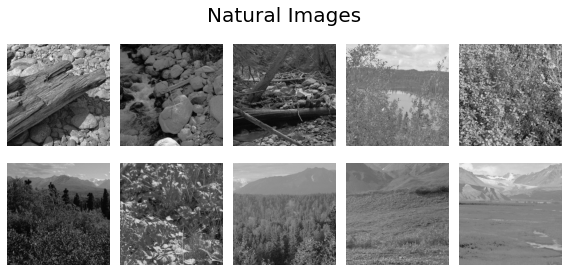

In [4]:
# Plot datasets
fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9)  

ここで、画像を読み込み、1つのパッチを作成するコードを確認のために記述します。赤枠の部分が切り取った画像パッチです。

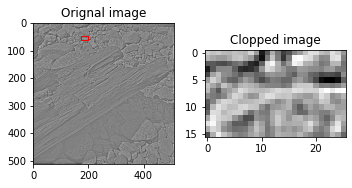

In [5]:
# Get image from imglist
img = imgs[:, :, 0]
H, W = img.shape

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = np.random.randint(0, W-27)
beginy = np.random.randint(0, H-17)
img_clopped = img[beginy:beginy+16, beginx:beginx+26]

# Clop three inputs
inputs = [img_clopped[:, 0:16], 
          img_clopped[:, 5:21], 
          img_clopped[:, 10:26]]

# Show clopped images
plt.figure(figsize=(5,10))
ax1 = plt.subplot(1,2,1)
plt.title("Orignal image")
plt.imshow(img, cmap="gray")
ax1.add_patch(patches.Rectangle(xy=(beginx, beginy), 
                                width=26, height=16, ec='red', fill=False))

ax2 = plt.subplot(1,2,2)
plt.title("Clopped image")
plt.imshow(img_clopped, cmap="gray")
plt.tight_layout()
plt.show()

### ネットワークの実装
ネットワークを実装します。`__init__`関数でネットワークの初期化をし、`__call__`関数でネットワークの1ステップの計算を行います。また、以下の実装では$f(x)=x$としました (元のディレクトリにある`network.py`には$f(x)=\tanh(x)$の実装も付けていますが、結果があまり変わりませんでした)。よってこのネットワークは線形となります。

In [6]:
class RaoBallard1999Model:
    def __init__(self, dt=1, sigma2=1, sigma2_td=10):
        self.dt = dt
        self.inv_sigma2 = 1/sigma2 # 1 / sigma^2        
        self.inv_sigma2_td = 1/sigma2_td # 1 / sigma_td^2
        
        self.k1 = 0.3 # k_1: update rate
        self.k2 = 0.2 # k_2: learning rate
        
        self.lam = 0.02 # sparsity rate
        self.alpha = 1
        self.alphah = 0.05
        
        self.num_units_level0 = 256
        self.num_units_level1 = 32
        self.num_units_level2 = 128
        self.num_level1 = 3
        
        U = np.random.randn(self.num_units_level0, 
                            self.num_units_level1)
        Uh = np.random.randn(int(self.num_level1*self.num_units_level1),
                             self.num_units_level2)
        self.U = U.astype(np.float32) * np.sqrt(2/(self.num_units_level0+self.num_units_level1))
        self.Uh = Uh.astype(np.float32) * np.sqrt(2/(int(self.num_level1*self.num_units_level1)+self.num_units_level2)) 
                
        self.r = np.zeros((self.num_level1, self.num_units_level1))
        self.rh = np.zeros((self.num_units_level2))
    
    def initialize_states(self, inputs):
        self.r = inputs @ self.U 
        self.rh = self.Uh.T @ np.reshape(self.r, (int(self.num_level1*self.num_units_level1)))
    
    def calculate_total_error(self, error, errorh):
        recon_error = self.inv_sigma2*np.sum(error**2) + self.inv_sigma2_td*np.sum(errorh**2)
        sparsity_r = self.alpha*np.sum(self.r**2) + self.alphah*np.sum(self.rh**2)
        sparsity_U = self.lam*(np.sum(self.U**2) + np.sum(self.Uh**2))
        return recon_error + sparsity_r + sparsity_U
        
    def __call__(self, inputs, training=False):
        # inputs : (3, 256)
        r_reshaped = np.reshape(self.r, (int(self.num_level1*self.num_units_level1))) # (96)

        fx = self.r @ self.U.T
        fxh = self.Uh @ self.rh # (96, )
        
        # Calculate errors
        error = inputs - fx # (3, 256)
        errorh = r_reshaped - fxh # (96, ) 
        errorh_reshaped = np.reshape(errorh, (self.num_level1, self.num_units_level1)) # (3, 32)
        
        g_r = self.alpha * self.r / (1 + self.r**2) # (3, 32)
        g_rh = self.alphah * self.rh / (1 + self.rh**2) # (64, )
        
        # Update r and rh
        dr = self.inv_sigma2 * error @ self.U - self.inv_sigma2_td * errorh_reshaped - g_r
        drh = self.inv_sigma2_td * self.Uh.T @ errorh - g_rh
        
        dr = self.k1 * dr
        drh = self.k1 * drh
        
        # Updates                
        self.r += dr
        self.rh += drh
        
        if training:  
            dU = self.inv_sigma2 * error.T @ self.r - 3*self.lam * self.U
            dUh = self.inv_sigma2_td * np.outer(errorh, self.rh) - self.lam * self.Uh
            
            self.U += self.k2 * dU
            self.Uh += self.k2 * dUh
            
        return error, errorh, dr, drh

元画像における赤枠の範囲が切り取った画像パッチです。右の画像パッチを更に3つに分割して、Gaussianフィルタを乗じた後にネットワークに入力します。

### モデルの定義
上で実装したネットワークを`model`として定義します。また、シミュレーションで用いる定数などを初期化しておきます。

In [7]:
# Define model
model = RaoBallard1999Model()

# Simulation constants
H, W, num_images = imgs.shape
nt_max = 1000 # Maximum number of simulation time
eps = 1e-3 # small value which determines convergence
input_scale = 40 # scale factor of inputs
gmask = GaussianMask() # Gaussian mask
error_list = [] # List to save errors

### シミュレーションの実行
シミュレーションを実行します。外側の`for loop`では画像パッチの作成と`r`と`rh`の初期化 (すなわちfeedforward処理の計算)を行います。内側の`for loop`では`r`および`rh`が収束するまで更新を行い、収束したときに重み行列`U`および`Uh`を更新します。また、`model.k2`は40画像パッチごとに1.015で除します。

In [8]:
for iter_ in tqdm(range(num_iter)):
    # Get images randomly
    idx = np.random.randint(0, num_images)
    img = imgs[:, :, idx]
    
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-27)
    beginy = np.random.randint(0, H-17)
    img_clopped = img[beginy:beginy+16, beginx:beginx+26]

    # Clop three inputs
    inputs = np.array([(gmask*img_clopped[:, i*5:i*5+16]).flatten() for i in range(3)])
    inputs = (inputs - np.mean(inputs)) * input_scale
    
    # Reset states
    model.initialize_states(inputs)
    
    # Input an image patch until latent variables are converged 
    for i in range(nt_max):
        # Update r and rh without update weights 
        error, errorh, dr, drh = model(inputs, training=False)
        
        # Compute norm of r and rh
        dr_norm = np.linalg.norm(dr, ord=2) 
        drh_norm = np.linalg.norm(drh, ord=2)
        
        # Check convergence of r and rh, then update weights
        if dr_norm < eps and drh_norm < eps:
            error, errorh, dr, drh = model(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if i >= nt_max-2: 
            print("Error at patch:", iter_)
            print(dr_norm, drh_norm)
            break
   
    error_list.append(model.calculate_total_error(error, errorh)) # Append errors

    # Decay learning rate         
    if iter_ % 40 == 39:
        model.k2 /= 1.015
    
    # Print moving average error
    if iter_ % 1000 == 999:  
        print("iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:", np.mean(error_list[iter_-999:iter_]))

iter: 1000/5000, Moving error: 2.1590278564615817
iter: 2000/5000, Moving error: 1.692464205507875
iter: 3000/5000, Moving error: 1.6900546798398537
iter: 4000/5000, Moving error: 1.7189523951808592
iter: 5000/5000, Moving error: 1.7695244313404115



### 訓練中の損失のplot

訓練中の損失(の移動平均)をplotする。

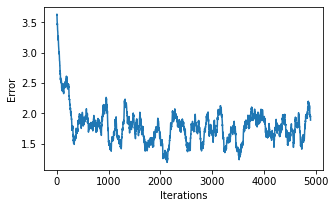

In [9]:
def moving_average(x, n=100) :
    ret = np.cumsum(x, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_error = moving_average(np.array(error_list))
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(moving_average_error)), moving_average_error)
plt.show()

### Level-1 moduleの重み行列のplot
学習後の重み行列を可視化してみましょう。中央部にしか受容野が無いように見えますが、これは画像パッチの入力時にGaussianフィルタを乗じているためです。このため、端に受容野が見えるということはこのネットワークではまずありません。

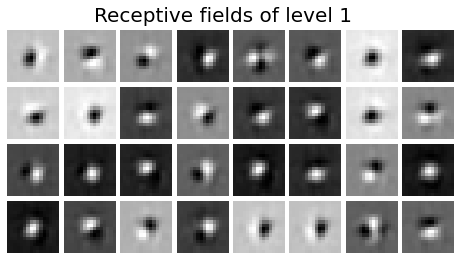

In [10]:
# Plot Receptive fields of level 1
fig = plt.figure(figsize=(8, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(np.reshape(model.U[:, i], (16, 16)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields of level 1", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表します。これは一次視覚野(V1)における**単純型細胞**([simple cell](https://en.wikipedia.org/wiki/Simple_cell))の受容野に類似しています。

なお、受容野について詳しくない場合は[受容野 - 脳科学辞典](https://bsd.neuroinf.jp/wiki/%E5%8F%97%E5%AE%B9%E9%87%8E)を参照してください。

### Level-2 moduleの重み行列のplot
Level-2 moduleはそのままではplotできないので、Level-1 moduleの重み行列をかけて統合します。こうすることで入力パッチの全体 (16 × 26)のサイズの受容野が得られます。128ニューロン全てを表示すると大きくなるので、36ニューロンの受容野のみを描画します。

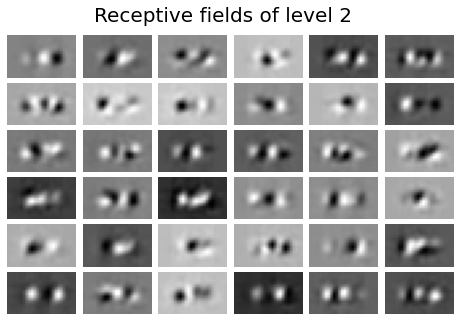

In [11]:
# Plot Receptive fields of level 2
zero_padding = np.zeros((80, 32))
U0 = np.concatenate((model.U, zero_padding, zero_padding))
U1 = np.concatenate((zero_padding, model.U, zero_padding))
U2 = np.concatenate((zero_padding, zero_padding, model.U))
U_ = np.concatenate((U0, U1, U2), axis = 1)
Uh_ = U_ @ model.Uh  

fig = plt.figure(figsize=(8, 5))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(np.reshape(Uh_[:, i], (16, 26), order='F'), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields of level 2", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

Level 1 moduleが単純型細胞のような受容野を持っていたので、その線形和であるLevel 2 moduleの受容野は**複雑型細胞**(complex cell)に類似していると言えます。ただ、複雑型細胞の受容野は元々可視化が困難(ON領域とOFF領域が重なり合うため)なので、この可視化から単純な比較はできません。

それでは論文内の結果と比較をしてみましょう。下図はFig. 2b-cで、上段がlevel-1 moduleの, 下段がlevel-2 moduleの受容野です。概ね再現できまていることが分かります。

<img src=" https://salad-bowl-of-knowledge.github.io/hp/images/copied_from_nb/images/predictive-coding_figs/fig2bc.JPG" width="500px">
<div style="text-align: right;"> (Rao and Ballard, 1999; Fig. 2b-c)</div>

tanhを活性化関数に用いた場合は(Olshausen & Field. *Nature*. 1996)のようなGaborフィルタが得られるようです (今回は再現できませんでしたが)。

<img src=" https://salad-bowl-of-knowledge.github.io/hp/images/copied_from_nb/images/predictive-coding_figs/fig2d.JPG" width="500px">
<div style="text-align: right;"> (Rao and Ballard, 1999; Fig. 2d)</div>

なお、論文はこれだけでは終わらず、長方形(棒)を入力した時の端点(endstopping)に対する応答を実際のニューロンの出力と比較する、などを行っています。

## まとめ
- Predictive codingの初めの数理モデルを実装した
- 誤差の順方向伝搬と予測の逆伝搬という構造は予測誤差 (≒自由エネルギー)を最小化するRNNを考慮することによって生まれた


## 参考文献
### 論文
- Rao RP, Ballard DH. [Predictive coding in the visual cortex: a functional interpretation of some extra-classical receptive-field effects](https://www.nature.com/articles/nn0199_79). *Nat Neurosci*. 1999;2(1):79–87. 
- Olshausen BA, Field DJ. [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://www.nature.com/articles/381607a0). Nature. 1996;381(6583):607–609. [Data and Code](http://www.rctn.org/bruno/sparsenet/)

### GitHubで確認した他の実装例
- https://github.com/lorenzohonegger/PredictiveCodingModel
- https://github.com/miyosuda/predictive_coding

### Rao先生の講義
- [Why Consider Probabilistic Models? Computational Reasons - PowerPoint PPT](https://www.slideserve.com/tracey/why-consider-probabilistic-models-computational-reasons-powerpoint-ppt-presentation)
- [7.3 Sparse Coding and Predictive Coding - Networks that Learn: Plasticity in the Brain & Learning (Rajesh Rao) | Coursera](https://www.coursera.org/lecture/computational-neuroscience/7-3-sparse-coding-and-predictive-coding-w2qIu)